In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cicids2017-cleaned-data/cleaned_data.csv
/kaggle/input/cleaned-data-2/cleaned_data2.csv


In [2]:
data = pd.read_csv("/kaggle/input/cleaned-data-2/cleaned_data2.csv")
data

,Destination Port,Flow Duration,Total Fwd Packets,Total Length of Fwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Bwd Packet Length Max,Bwd Packet Length Min,Flow Bytes/s,...,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Std,Attack_Type
0,22,1266342,41,2664,456,0,64.975610,976,0,7.595105e+03,...,29200,243,24,32,0.0,0.0,0,0,0.0,BENIGN
1,22,1319353,41,2664,456,0,64.975610,976,0,7.289937e+03,...,29200,243,24,32,0.0,0.0,0,0,0.0,BENIGN
2,22,160,1,0,0,0,0.000000,0,0,0.000000e+00,...,290,243,0,32,0.0,0.0,0,0,0.0,BENIGN
3,22,1303488,41,2728,456,0,66.536585,976,0,7.182268e+03,...,29200,243,24,32,0.0,0.0,0,0,0.0,BENIGN
4,35396,77,1,0,0,0,0.000000,0,0,0.000000e+00,...,243,290,0,32,0.0,0.0,0,0,0.0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2520746,53,32215,4,112,28,28,28.000000,76,76,8.194940e+03,...,-1,-1,3,20,0.0,0.0,0,0,0.0,BENIGN
2520747,53,324,2,84,42,42,42.000000,181,181,1.376543e+06,...,-1,-1,1,20,0.0,0.0,0,0,0.0,BENIGN
2520748,58030,82,2,31,31,0,15.500000,6,6,4.512195e+05,...,1006,0,0,32,0.0,0.0,0,0,0.0,BENIGN
2520749,53,1048635,6,192,32,32,32.000000,128,128,4.272221e+02,...,-1,-1,5,20,0.0,0.0,0,0,0.0,BENIGN


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Separate features and target
X = data.drop(columns=['Attack_Type'])
y = data['Attack_Type']

# Encode target labels (required for XGBoost multi-class)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Train-test split (stratify to maintain class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)


In [4]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from xgboost import XGBClassifier

# Build the pipeline
pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('xgb', XGBClassifier(
        objective='multi:softmax',
        eval_metric='mlogloss',
        n_estimators=150,
        max_depth=6,
        learning_rate=0.1,
        use_label_encoder=False,
        n_jobs=-1,
        random_state=42
    ))
])


In [5]:
pipeline.fit(X_train, y_train)


Pipeline(steps=[('scaler', RobustScaler()),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='mlogloss',
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=150, n_jobs=-1,
                               num_parallel_tree=None,
                               objective='multi:softmax', ...))])

In [6]:
import joblib
joblib.dump(pipeline, 'xgb_pipeline1.pkl')

['xgb_pipeline1.pkl']

In [7]:
from sklearn.metrics import classification_report, confusion_matrix

# Make predictions
y_pred = pipeline.predict(X_test)

# Print classification report
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Examine precision, recall, and f1-score for each class
# Useful for imbalanced data
# High precision = fewer false positives
# High recall = fewer false negatives

# Look for classes with low recall → model missing them
# Look for classes with low precision → model confusing them with others


              precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00    628518
         Bot       0.96      0.72      0.82       584
 Brute Force       1.00      1.00      1.00      2745
        DDoS       1.00      1.00      1.00     38404
         DoS       1.00      1.00      1.00     58124
    PortScan       0.99      1.00      0.99     27208
  Web Attack       0.98      0.99      0.99       643

    accuracy                           1.00    756226
   macro avg       0.99      0.96      0.97    756226
weighted avg       1.00      1.00      1.00    756226



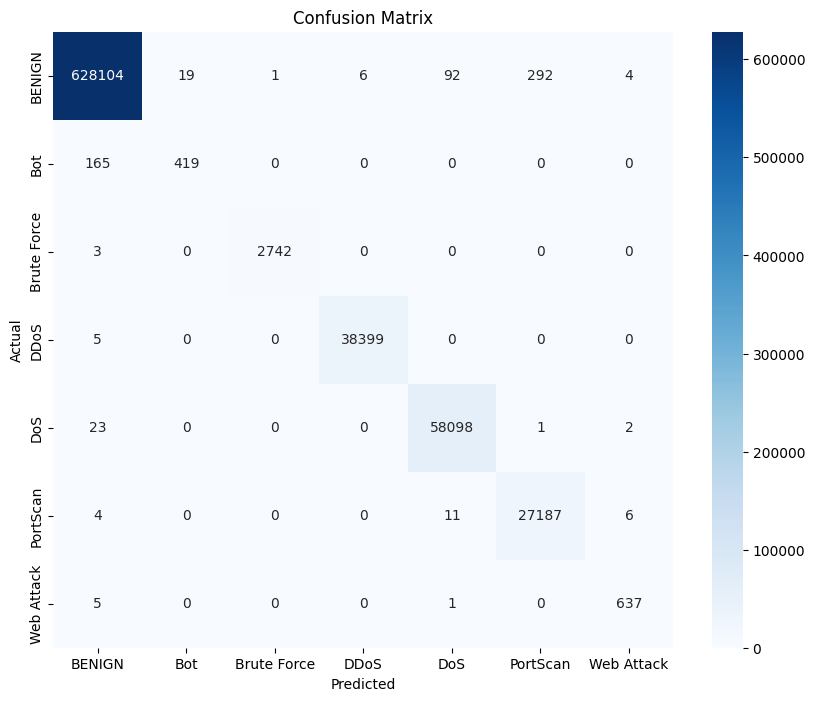

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Helps visualize which classes are most confused
# Focus on off-diagonal values — that’s where misclassifications happen


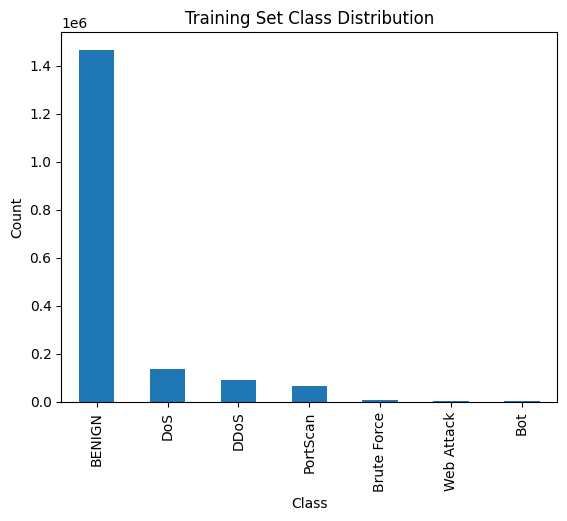

In [9]:
import pandas as pd

# See how imbalanced the classes are
pd.Series(le.inverse_transform(y_train)).value_counts().plot(kind='bar', title='Training Set Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# Compare this to classification report: classes with fewer samples usually have lower recall


The imbalance is too great. It might be the cause of bad results on the "web attack" class. We will try downsampling of the benign class.

In [10]:
from sklearn.utils import resample, shuffle
import numpy as np
import pandas as pd

# Get the encoded value for "BENIGN"
benign_label = le.transform(["BENIGN"])[0]
print(f'"BENIGN" was encoded to: {benign_label}')

# Print original data sizes
print("Original dataset size:", len(X_train))
print("Original BENIGN count:", sum(y_train == benign_label))
print("Original non-BENIGN count:", sum(y_train != benign_label))

# Separate BENIGN and non-BENIGN samples
benign_indices = np.where(y_train == benign_label)[0]
non_benign_indices = np.where(y_train != benign_label)[0]

benign_train = X_train.iloc[benign_indices]
benign_labels = y_train[benign_indices]
non_benign_train = X_train.iloc[non_benign_indices]
non_benign_labels = y_train[non_benign_indices]

print("Separated BENIGN count:", len(benign_train))
print("Separated non-BENIGN count:", len(non_benign_train))

# Downsample BENIGN class (keep 30%)
n_samples = int(len(benign_train) * 0.3)
print(f"Downsampling BENIGN class to {n_samples} samples (30% of original)")

benign_train_downsampled, benign_labels_downsampled = resample(
    benign_train,
    benign_labels,
    replace=False,
    n_samples=n_samples,
    random_state=42
)

# Combine downsampled BENIGN with other classes
X_train_downsampled = pd.concat([benign_train_downsampled, non_benign_train])
y_train_downsampled = np.concatenate([benign_labels_downsampled, non_benign_labels])

# Shuffle the new training set
X_train_downsampled, y_train_downsampled = shuffle(X_train_downsampled, y_train_downsampled, random_state=42)

# Final verification
print("\nFinal verification:")
print("Downsampled dataset size:", len(X_train_downsampled))
print("Downsampled BENIGN count:", sum(y_train_downsampled == benign_label))
print("Downsampled non-BENIGN count:", sum(y_train_downsampled != benign_label))


"BENIGN" was encoded to: 0
Original dataset size: 1764525
Original BENIGN count: 1466539
Original non-BENIGN count: 297986
Separated BENIGN count: 1466539
Separated non-BENIGN count: 297986
Downsampling BENIGN class to 439961 samples (30% of original)

Final verification:
Downsampled dataset size: 737947
Downsampled BENIGN count: 439961
Downsampled non-BENIGN count: 297986


In [11]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from xgboost import XGBClassifier

# Build the pipeline
pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('xgb', XGBClassifier(
        objective='multi:softmax',
        eval_metric='mlogloss',
        n_estimators=150,
        max_depth=6,
        learning_rate=0.1,
        use_label_encoder=False,
        n_jobs=-1,
        random_state=42
    ))
])


In [12]:
pipeline.fit(X_train_downsampled, y_train_downsampled)

Pipeline(steps=[('scaler', RobustScaler()),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='mlogloss',
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=150, n_jobs=-1,
                               num_parallel_tree=None,
                               objective='multi:softmax', ...))])

In [13]:
import joblib
joblib.dump(pipeline, 'xgb_pipeline2.pkl')

['xgb_pipeline2.pkl']

In [14]:
from sklearn.metrics import classification_report, confusion_matrix

# Make predictions
y_pred = pipeline.predict(X_test)

# Print classification report
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Examine precision, recall, and f1-score for each class
# Useful for imbalanced data
# High precision = fewer false positives
# High recall = fewer false negatives

# Look for classes with low recall → model missing them
# Look for classes with low precision → model confusing them with others


              precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00    628518
         Bot       0.66      0.97      0.79       584
 Brute Force       1.00      1.00      1.00      2745
        DDoS       1.00      1.00      1.00     38404
         DoS       1.00      1.00      1.00     58124
    PortScan       0.99      1.00      0.99     27208
  Web Attack       0.98      0.99      0.98       643

    accuracy                           1.00    756226
   macro avg       0.95      0.99      0.97    756226
weighted avg       1.00      1.00      1.00    756226



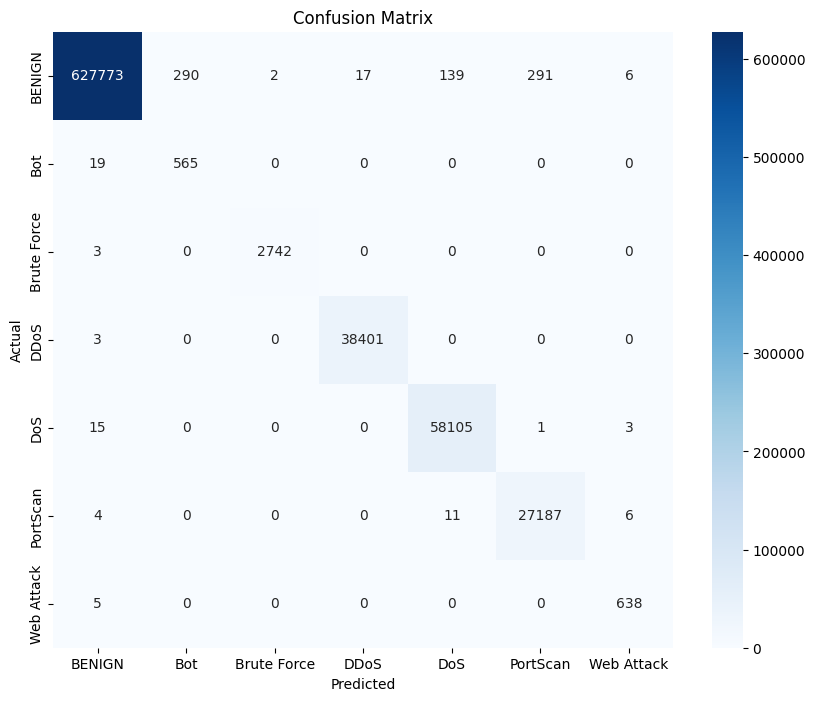

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Helps visualize which classes are most confused
# Focus on off-diagonal values — that’s where misclassifications happen


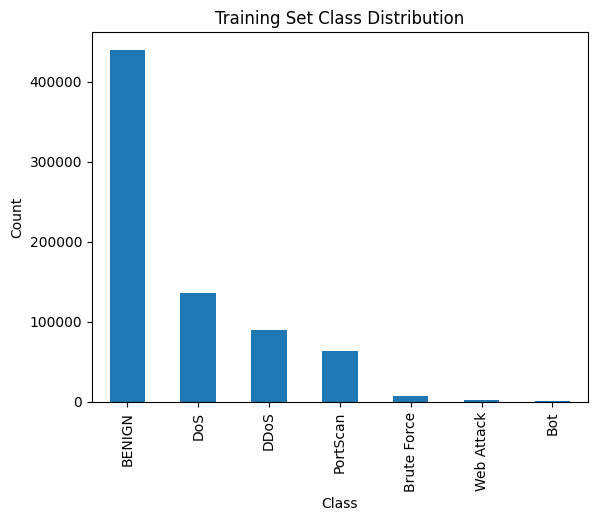

In [16]:
import pandas as pd

# See how imbalanced the classes are
pd.Series(le.inverse_transform(y_train_downsampled)).value_counts().plot(kind='bar', title='Training Set Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# Compare this to classification report: classes with fewer samples usually have lower recall


In [17]:
print(data["Attack_Type"].unique())

['BENIGN' 'PortScan' 'Web Attack' 'Brute Force' 'DDoS' 'Bot' 'DoS']


The model before undersampling performed better. Therefore,we will take it. 